# Basic Implementation

In [ ]:
# Import Dependencies
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
# Define the classic SIR model as an ODE
def SIR(A,t, beta, gamma, N):
    S, I, R = A  # A has S, I and R

    # Differential equations
    dSdt = -beta/N * S * I # Rate of change of susceptible individuals
    dIdt = beta/N * S * I - gamma * I # Rate of change of infected individuals
    dRdt = gamma * I # Rate of change of recovered individuals

    return [dSdt, dIdt, dRdt]

In [ ]:
N_days = 100  # Duration of the simulation (in days)

# Ground Truth Values for True infection and recovery rates (used for synthetic data generation)
beta = 0.39 # τSI (infection rate)
gamma = 0.1  # τIR (recovery rate)

N = 1.1e7 # Population size
times = np.arange(0, N_days ,1)  # Time range
S0, I0, R0 = N - 574, 574, 0 # Initial conditions: [Susceptible, Infected, Recovered]

sol = odeint(SIR, y0=[S0,I0,R0], t=times, args=(beta, gamma, N)).T
print(sol.shape) # (3,25)

(3, 100)


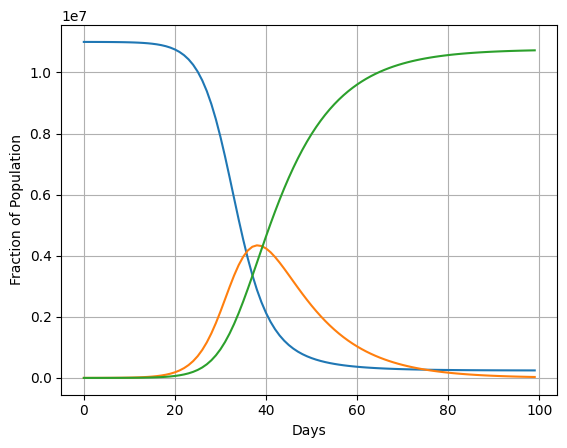

In [ ]:
# Plot the results
S = sol[0]
I = sol[1]
R = sol[2]

plt.plot(times, S, label="Susceptible")
plt.plot(times, I, label="Infected")
plt.plot(times, R, label="Recovered")
plt.xlabel('Days')
plt.ylabel('Fraction of Population')
plt.grid()

# Scientific ML Implementation

In [18]:
!pip install torchdiffeq -qU # Allows you to solve ordinary differential equations (ODEs) directly within PyTorch.

In [2]:
# Import Dependencies
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import odeint
from torchdiffeq import odeint as odeint_torch
import matplotlib.pyplot as plt

In [3]:
# SIR Model Parameters
N = 1.1e7  # Total population
beta = 0.85  # Infection rate
gamma = 0.1  # Recovery rate
N_days = 100
t = np.arange(0, N_days, 1)

# Initial conditions
S0 = 0.99 * N
I0 = 0.01 * N
R0 = 0
u0 = [S0, I0, R0]

In [10]:
# 1. Define SIR Model
def SIR(A, t, beta, gamma, N):
    S, I, R = A
    dSdt = -beta / N * S * I
    dIdt = beta / N * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

true_solution = odeint(SIR, u0, t, args=(beta, gamma, N))
S_true, I_true, R_true = true_solution.T

# 2. Define Neural Network (UDE)
class UDE(nn.Module):
    def __init__(self):
        super(UDE, self).__init__()
        self.hidden = nn.Linear(3, 10)  # Input: S, I, R
        self.output = nn.Linear(10, 3)  # Output: Corrections for S, I, R

    def forward(self, A):
        A = torch.relu(self.hidden(A))
        return self.output(A)

ude_model = UDE()

# 3. UDE-Enhanced SIR Model
# UDE-Enhanced SIR Model as a class to pass arguments
class UDE_SIR(nn.Module):
    def __init__(self, beta, gamma, N, ude_model):
        super(UDE_SIR, self).__init__()
        self.beta = beta
        self.gamma = gamma
        self.N = N
        self.ude_model = ude_model

    def forward(self, t, A):
        S, I, R = A
        dSdt = -self.beta / self.N * S * I
        dIdt = self.beta / self.N * S * I - self.gamma * I
        dRdt = self.gamma * I

        # Neural Network for Corrections
        A_tensor = torch.stack([S, I, R]).requires_grad_()
        corrections = self.ude_model(A_tensor)

        # Apply Corrections
        dSdt += corrections[0]
        dIdt += corrections[1]
        dRdt += corrections[2]

        return torch.stack([dSdt, dIdt, dRdt])

In [17]:
# Training Parameters
learning_rate = 1e-5
n_epochs = 1000
optimizer = optim.Adam(ude_model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

# Prepare Training Data
train_data = torch.tensor(np.vstack([S_true, I_true, R_true]).T, dtype=torch.float32)

# Initial Conditions for Torch
u0_tensor = torch.tensor(u0, dtype=torch.float32, requires_grad=True)
t_tensor = torch.tensor(t, dtype=torch.float32)

# Training Loop
for epoch in range(n_epochs):
    optimizer.zero_grad()

    ude_sir_model = UDE_SIR(beta, gamma, N, ude_model)

    # UDE-enhanced solution using Torch ODE
    ude_solution = odeint_torch(ude_sir_model, u0_tensor, t_tensor)
    S_pred, I_pred, R_pred = ude_solution.T


    # Prepare Prediction Data for Loss
    predicted_data = torch.stack([S_pred, I_pred, R_pred], dim=1)

    # Compute Loss
    loss = loss_function(predicted_data, train_data)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch [{epoch}/{n_epochs}], Loss: {loss.item():.6f}')

print("✅ Training complete!")

Epoch [0/1000], Loss: 460146212864.000000
Epoch [50/1000], Loss: 448262602752.000000
Epoch [100/1000], Loss: 436190347264.000000
Epoch [150/1000], Loss: 424214134784.000000
Epoch [200/1000], Loss: 412360409088.000000
Epoch [250/1000], Loss: 400642670592.000000
Epoch [300/1000], Loss: 389071470592.000000
Epoch [350/1000], Loss: 377674366976.000000
Epoch [400/1000], Loss: 366216249344.000000
Epoch [450/1000], Loss: 354132918272.000000
Epoch [500/1000], Loss: 342993436672.000000
Epoch [550/1000], Loss: 332241731584.000000
Epoch [600/1000], Loss: 321839955968.000000
Epoch [650/1000], Loss: 311777198080.000000
Epoch [700/1000], Loss: 302051360768.000000
Epoch [750/1000], Loss: 292660674560.000000
Epoch [800/1000], Loss: 283596881920.000000
Epoch [850/1000], Loss: 274854952960.000000
Epoch [900/1000], Loss: 266437378048.000000
Epoch [950/1000], Loss: 258336014336.000000
✅ Training complete!


In [19]:
# Wrapper class to plot results
class UDESIRWrapper(nn.Module):
    def __init__(self, beta, gamma, N, ude_model):
        super(UDESIRWrapper, self).__init__()
        self.beta = beta
        self.gamma = gamma
        self.N = N
        self.ude_model = ude_model

    def forward(self, t, u):
        S, I, R = u

        # UDE correction
        correction = self.ude_model(torch.tensor([S, I, R], dtype=torch.float32)).squeeze()

        # If the correction has 3 values, split them correctly
        if len(correction) == 3:
            dS_corr, dI_corr, dR_corr = correction
        else:
            dS_corr, dI_corr, dR_corr = 0, 0, 0

        # UDE-corrected SIR equations
        dS = -self.beta * S * I / self.N + dS_corr
        dI = self.beta * S * I / self.N - self.gamma * I + dI_corr
        dR = self.gamma * I + dR_corr

        return torch.stack([dS, dI, dR]).reshape(3)

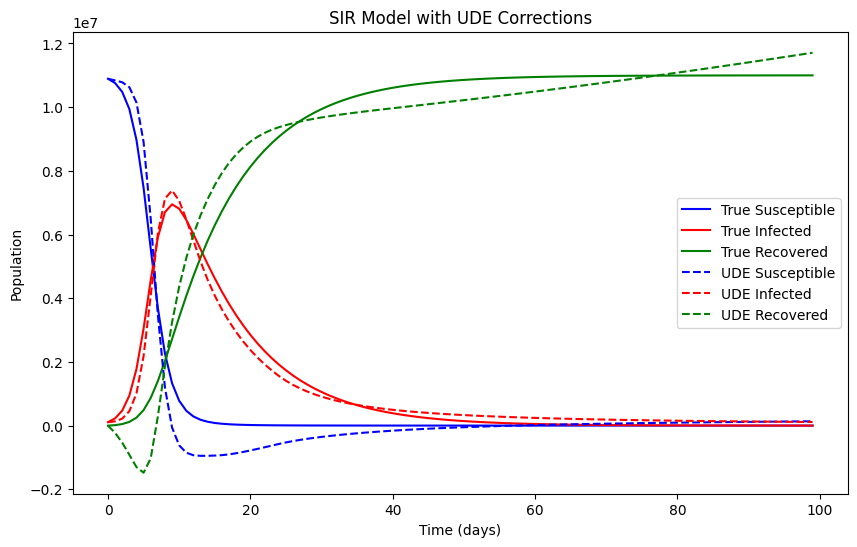

In [20]:
# Plot UDE Results
# Instantiate the corrected UDE SIR model
ude_sir_model = UDESIRWrapper(beta, gamma, N, ude_model)

# Solve the system using the trained UDE SIR model
ude_solution = odeint_torch(ude_sir_model, u0_tensor, t_tensor)
S_pred, I_pred, R_pred = ude_solution.T.detach().numpy()

plt.figure(figsize=(10, 6))
plt.plot(t, S_true, 'b', label='True Susceptible')
plt.plot(t, I_true, 'r', label='True Infected')
plt.plot(t, R_true, 'g', label='True Recovered')
plt.plot(t, S_pred, 'b--', label='UDE Susceptible')
plt.plot(t, I_pred, 'r--', label='UDE Infected')
plt.plot(t, R_pred, 'g--', label='UDE Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.legend()
plt.title('SIR Model with UDE Corrections')
plt.show()